In [1]:
import os
import time

import numpy as np
import pandas as pd

import binarytree as bt
import igraph as ig

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from itertools import product

from scipy.spatial import distance

In [2]:
def EXP3(actions, rate):
    # Losses of Experts
    losses = np.zeros(actions)
    
    # Losses of Learner
    losses_exp = np.zeros(trials)
    
    # Weights of Experts
    weights = np.full(actions, np.divide(1.0, actions))
    
    for t in range(trials):
        # Sample an Action Based on Weights
        choice = np.random.choice(actions, p = weights)
        
        # Initialize Random Losses for Different Experts
        losses = np.random.uniform(high = typical, size = actions)
        losses[0] = np.random.uniform(high = optimal)
        
        # Incur Loss of Learner
        losses_exp[t] = losses[choice]
        
        # Update Weights
        scaled = np.divide(losses[choice], weights[choice])
        weights[choice] *= np.exp(np.multiply(-rate, scaled))
        
        weights = np.divide(weights, np.sum(weights))
    
    total_loss = np.sum(losses_exp)
    print(f'Total Loss: {total_loss}')
    
    output = np.cumsum(losses_exp)
    
    return output

In [3]:
users = 32

cwd = os.getcwd()
path = os.path.join(cwd, 'Files', 'data.dat')

with open(path) as f:
    lines = f.readlines()

np.random.shuffle(lines)
elements = lines[ : users]

labels = []
matrix = []

for i in elements:
    values = i.split()
    
    labels.append(values[0])
    matrix.append(values[1 : ])

# print(labels)
# print(matrix)

In [4]:
KNN = 3

df_matrix = pd.DataFrame(matrix)
df_matrix = df_matrix.apply(pd.to_numeric, errors = 'ignore')

# Euclidean Distance
dist = distance.cdist(df_matrix, df_matrix, 'euclid')
df_dist = pd.DataFrame(dist)

# K-Nearest Neighbors
knn = np.argsort(df_dist.values, axis = 1)[ : , 1 : KNN + 1]
df_knn = pd.DataFrame(knn)

# Adjacency Matrix
df_am = pd.DataFrame(np.zeros(df_dist.shape))

for i, row in df_knn.iterrows():
    df_am.loc[row.values, i] = 1.0
    df_am.loc[i, row.values] = 1.0

df_am.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


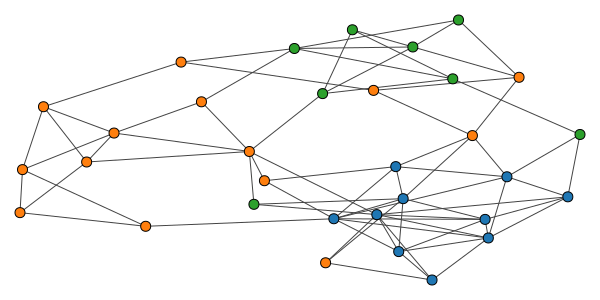

In [5]:
graph = ig.Graph.Adjacency(df_am.values)
graph.to_undirected()

color_map = {}
palette = cm.tab10.colors

unique = set(labels)
classes = len(unique)

for index, label in enumerate(unique):
    color_map[label] = palette[index]

colors = [color_map[i] for i in labels]

visual_style = {}

visual_style['vertex_size'] = 10
visual_style['vertex_color'] = colors
visual_style['bbox'] = (600, 300)

layout = graph.layout('auto')
ig.plot(graph, layout = layout, **visual_style)

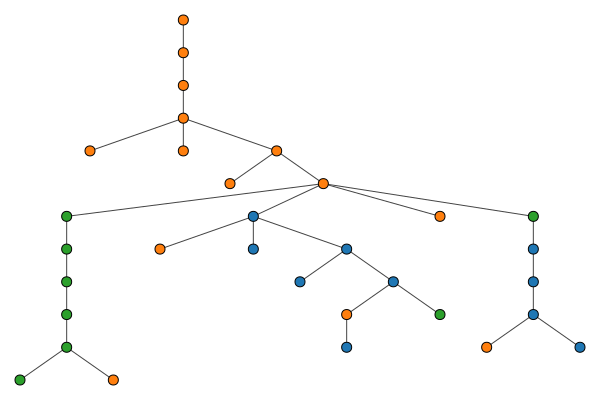

In [6]:
# Random Spanning Tree (RST) #

root = 0

def RST(graph, root = root):
    edges, visited = [], [root]
    
    node = root
    
    while (len(visited) < graph.vcount()):
        neighbors = graph.neighbors(node)
        choice = np.random.choice(neighbors)
        
        if choice not in visited:
            visited.append(choice)
            edges.append((node, choice))
        
        node = choice
    
    return edges

edges = RST(graph)

rst = ig.Graph(edges = edges)

visual_style = {}

visual_style['vertex_size'] = 10
visual_style['vertex_color'] = colors
visual_style['bbox'] = (600, 400)

layout = rst.layout('tree', root = [root])
layout.mirror(0)

ig.plot(rst, layout = layout, **visual_style)

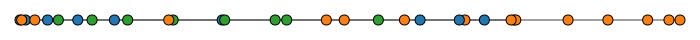

In [7]:
# Depth-First Search #

vertices, parents = rst.dfs(vid = root)
# print(vertices)

edges = zip(vertices, vertices[1 : ])
spine = ig.Graph(edges = edges)

visual_style = {}

visual_style['vertex_size'] = 10
visual_style['vertex_color'] = colors
visual_style['bbox'] = (700, 40)

layout = spine.layout('drl')
ig.plot(spine, layout = layout, **visual_style)

In [8]:
def init_matching():
    spine = map(float, [labels[i] for i in vertices])
    return np.fromiter(spine, dtype = int) - 1

def init_stochastic():
    return np.random.randint(low = 0, high = classes, size = users)

def init_uniform(value = 0):
    return np.full(users, value, dtype = int)

In [9]:
# Forward-Backward #

beta = 0.1

# Helper Functions

def transition(a, b):
    if (a == b): return (1 - beta)
    return np.divide(beta, actions - 1)

def FW(pi, fi, u, a):
    transitions = np.full(actions, transition(0, 1))
    transitions[a] = transition(0, 0)
    
    return np.sum(np.multiply(fi[u - 1], transitions))

def BW(pi, psi, u, a):
    transitions = np.full(actions, transition(0, 1))
    transitions[a] = transition(0, 0)
    
    x = np.multiply(pi[u + 1], psi[u + 1])
    
    return np.sum(np.multiply(x, transitions))

# Main Function

def FB(pi, fi, psi):
    _users, _actions = range(users), range(actions)
    
    # Combinations of Users and Actions
    f_combinations = product(_users[1 : ], _actions)
    b_combinations = product(_users[-2 : : -1], _actions)
    
    # Forward Pass
    fi[0] = pi[0]
    
    for u, a in f_combinations:
        fi[u][a] = np.multiply(pi[u][a], FW(pi, fi, u, a))
    
    # Backward Pass
    psi[-1] = 1.0
    
    for u, a in b_combinations:
        psi[u][a] = BW(pi, psi, u, a)
    
    return fi, psi

In [10]:
# Multi-Task Hedge #

# Full Information
def MTH_F(method):
    # Losses of Experts
    losses = np.zeros(actions)
    
    # Losses of Learner
    losses_mth = np.zeros(trials)
    
    # Best Actions of Users
    best_actions = method()
    
    shape = (users, actions)
    
    pi = np.ones(shape)
    fi = np.ones(shape)
    psi = np.ones(shape)
    
    for t in range(trials):
        # Environment Selects User
        index = np.random.randint(users)
        best = best_actions[index]
        
        # Initialize Random Losses for Different Experts
        losses = np.random.uniform(high = typical, size = actions)
        losses[best] = np.random.uniform(high = optimal)
        
        # Determine Fi and Psi
        fi, psi = FB(pi, fi, psi)
        
        # Determine Prediction
        prediction = np.multiply(fi[index], psi[index])
        prediction = np.divide(prediction, np.sum(prediction))
        
        # Incur Loss of Learner
        losses_mth[t] = np.dot(prediction, losses)
        
        # Update Pi
        pi[index] *= np.exp(np.multiply(-rate, losses))
    
    total_loss = np.sum(losses_mth)
    print(f'Total Loss: {total_loss}')
    
    output = np.cumsum(losses_mth)
    
    return output

# Bandit Setting
def MTH_B(method):
    # Losses of Experts
    losses = np.zeros(actions)
    
    # Losses of Learner
    losses_mth = np.zeros(trials)
    
    # Best Actions of Users
    best_actions = method()
    
    shape = (users, actions)
    
    pi = np.ones(shape)
    fi = np.ones(shape)
    psi = np.ones(shape)
    
    for t in range(trials):
        # Environment Selects User
        index = np.random.randint(users)
        best = best_actions[index]
        
        # Initialize Random Losses for Different Experts
        losses = np.random.uniform(high = typical, size = actions)
        losses[best] = np.random.uniform(high = optimal)
        
        # Determine Fi and Psi
        fi, psi = FB(pi, fi, psi)
        
        # Determine Prediction
        prediction = np.multiply(fi[index], psi[index])
        prediction = np.divide(prediction, np.sum(prediction))
        
        # Sample an Action Based on Prediction Vector
        choice = np.random.choice(actions, p = prediction)
        
        # Incur Loss of Learner
        losses_mth[t] = losses[choice]
        
        # Update Pi
        scaled = np.divide(losses[choice], prediction[choice])
        pi[index][choice] *= np.exp(np.multiply(-rate, scaled))
    
    total_loss = np.sum(losses_mth)
    print(f'Total Loss: {total_loss}')
    
    output = np.cumsum(losses_mth)
    
    return output

In [11]:
# Binary Support Tree (BST) #

def ancestors(tree, value):
    ancestors = []
    
    for n in tree:
        if (value in n.values):
            ancestors.append(n)
    
    return ancestors

height = np.log2(users)

tree = bt.tree(height = int(height), is_perfect = True)

size, height = tree.size, tree.height
values, leaves = tree.values, tree.leaves

In [12]:
# GABA-I #

# Helper Functions

def init_alpha(shape, b):
    ones = np.ones(actions)
    alpha = np.zeros(shape)
    
    combinations = product(leaves, b, b)
    
    for n, i, j in combinations:
        if (i != j): alpha[n.value][i][j] = np.multiply(f, ones)
        if (i == j): alpha[n.value][i][j] = np.multiply(1 - f, ones)
    
    for d in range(1, height):
        combinations = product(tree.levels[height - d], b, b, b)
        
        for n, i, j, k in combinations:
            alpha_l = alpha[n.left.value][i][k]
            alpha_r = alpha[n.right.value][k][j]
            
            alpha[n.value][i][j] += np.multiply(alpha_l, alpha_r)
    
    return alpha

def update_alpha(alpha, anc, pi, b):
    ones = np.ones(actions)
    
    alpha[anc[height].value][1] *= pi
    combinations = product(anc[1 : height], b, b, b)
    
    for v, i, j, k in combinations:
        if (k == 0): alpha[v.value][i][j] = 0.0
        
        alpha_l = alpha[v.left.value][i][k]
        alpha_r = alpha[v.right.value][k][j]
        
        alpha[v.value][i][j] += np.multiply(alpha_l, alpha_r)
    
    return alpha

def init_beta(shape, alpha, anc, b):
    ones = np.ones(actions)
    
    beta_r, beta_l = np.zeros(shape), np.zeros(shape)
    
    beta_r[0][0], beta_r[0][1] = ones, ones
    
    beta_l[0][0] = np.multiply(np.divide(ones, actions), actions - 1)
    beta_l[0][1] = np.divide(ones, actions)
    
    for d in range(1, height + 1):
        if (anc[d] == anc[d - 1].left):
            for i, j in product(b, b):
                beta_p = beta_r[d - 1][j]
                alpha_r = alpha[anc[d - 1].right.value][i][j]
                
                beta_l[d][i] = beta_l[d - 1][i]
                beta_r[d][i] += np.multiply(alpha_r, beta_p)
        
        if (anc[d] == anc[d - 1].right):
            for i, j in product(b, b):
                beta_p = beta_l[d - 1][j]
                alpha_l = alpha[anc[d - 1].left.value][j][i]
                
                beta_r[d][i] = beta_r[d - 1][i]
                beta_l[d][i] += np.multiply(alpha_l, beta_p)
    
    return beta_l, beta_r

# Main Function

def GABA_I(method):
    # Losses of Experts
    losses = np.zeros(actions)
    
    # Losses of Learner
    losses_gaba = np.zeros(trials)
    
    # Best Actions of Users
    best_actions = method()
    
    b = [0, 1]
    
    # Initialize Alpha
    shape = (size, len(b), len(b), actions)
    alpha = init_alpha(shape, b)
    
    for t in range(trials):
        # Environment Selects User
        index = np.random.randint(users)
        best = best_actions[index]
        
        # Determine Ancestors
        anc = ancestors(tree, leaves[index].value)
        
        # Initialize Random Losses for Different Experts
        losses = np.random.uniform(high = typical, size = actions)
        losses[best] = np.random.uniform(high = optimal)
        
        # Initialize Beta
        shape = (len(anc), len(b), actions)
        beta_l, beta_r = init_beta(shape, alpha, anc, b)
        
        # Calculate Probability Vector
        m, n = beta_l[height][1], beta_r[height]
        o = alpha[anc[height].value][1]
        
        p = np.multiply(m, np.multiply(n, o)).sum(axis = 0)
        
        prediction = np.divide(p, actions)
        norm = np.sum(prediction)
        
        probability = np.divide(prediction, norm)
        
        # Sample an Action Based on Probability Vector
        choice = np.random.choice(actions, p = probability)
        
        # Incur Loss of Learner
        losses_gaba[t] = losses[choice]
        
        # Calculate C
        c = np.ones(actions)
        
        c[choice] = np.multiply(-rate, losses[choice])
        c[choice] = np.divide(c[choice], probability[choice])
        
        c[choice] = np.exp(c[choice])
        
        # Calculate Pi
        pi = np.divide(np.multiply(norm, c), np.dot(prediction, c))
        
        # Update Alpha
        alpha = update_alpha(alpha, anc, pi, b)
    
    total_loss = np.sum(losses_gaba)
    print(f'Total Loss: {total_loss}')
    
    output = np.cumsum(losses_gaba)
    
    return output

In [13]:
# Plot Function #

def plot(graphs, labels, title = ''):
    x = np.linspace(1, trials, num = trials)
    
    opt = np.multiply(x, np.divide(optimal, 2.0))
    typ = np.multiply(x, np.divide(typical, 2.0))
    
    fig, ax = plt.subplots(figsize = (10, 6))
    
    ax.plot(opt, label = 'Optimal')
    ax.plot(typ, label = 'Typical')
    
    for graph, label in zip(graphs, labels):
        ax.plot(graph, label = label)
    
    plt.xlabel('Trials', fontsize = 12)
    plt.ylabel('Cumulative Loss', fontsize = 12)
    
    plt.legend(loc = 'best')
    plt.title(title, fontsize = 12)
    
    plt.show()

In [14]:
# Experiments #

f = 0.1

beta = 0.1
rate = 0.2

optimal = 0.1
typical = 0.2

Total Loss: 604.7332644128591
Time: 0.34801411628723145


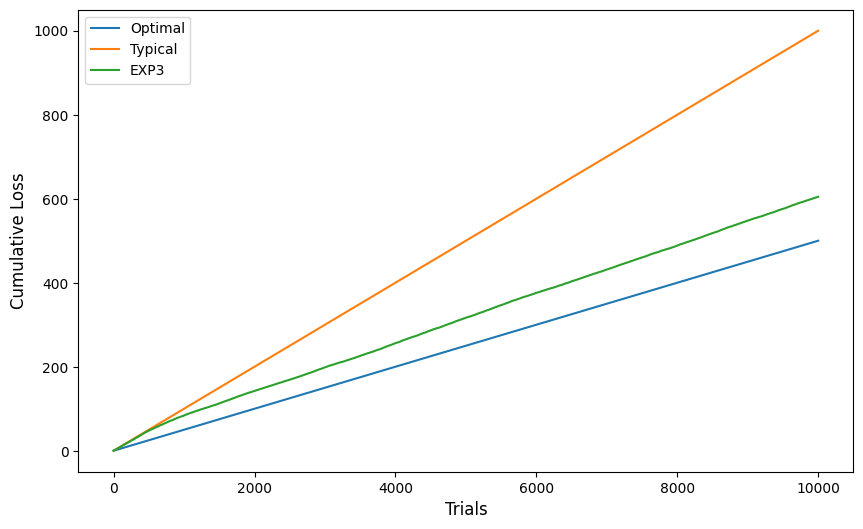

In [15]:
# EXP3 - Time
trials = 10000

start = time.time()
EXP3_T = EXP3(32, rate)
end = time.time()

print(f'Time: {end - start}')
plot([EXP3_T], ['EXP3'])

Total Loss: 537.4328115798617
Total Loss: 579.1863639466992
Total Loss: 659.6824751457938


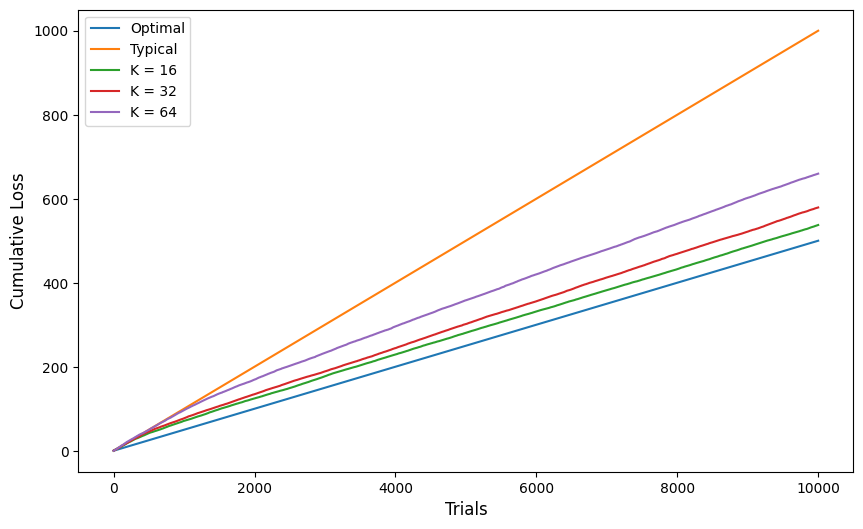

In [16]:
# EXP3 - Actions
trials = 10000

EXP3_16 = EXP3(16, rate)
EXP3_32 = EXP3(32, rate)
EXP3_64 = EXP3(64, rate)

plot([EXP3_16, EXP3_32, EXP3_64], ['K = 16', 'K = 32', 'K = 64'])

Total Loss: 527.3587665043561
Total Loss: 787.889331387833
Total Loss: 687.2716922534484
Time: 274.65323758125305


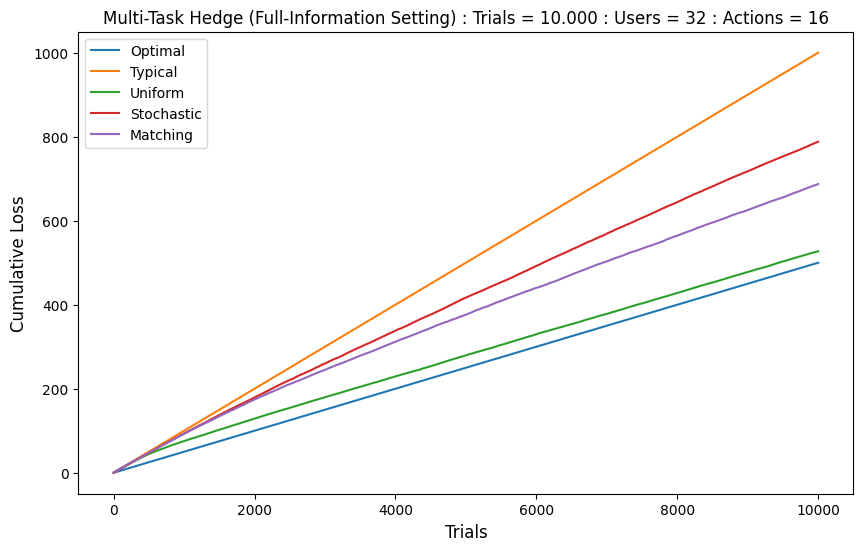

In [17]:
# Multi-Task Hedge #

actions = 16
trials = 10000

start = time.time()
MTH_U = MTH_F(init_uniform)
MTH_S = MTH_F(init_stochastic)
MTH_M = MTH_F(init_matching)
end = time.time()

print(f'Time: {end - start}')

title = 'Multi-Task Hedge (Full-Information Setting) : Trials = 10.000 : Users = 32 : Actions = 16'
plot([MTH_U, MTH_S, MTH_M], ['Uniform', 'Stochastic', 'Matching'], title)

Total Loss: 592.3384554472409
Total Loss: 858.9669697981385
Total Loss: 773.7436379666688
Time: 277.99697828292847


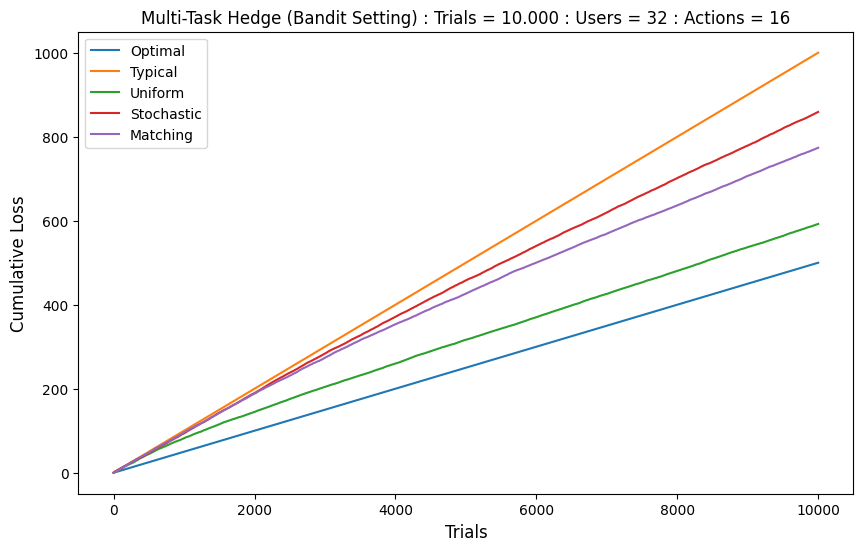

In [18]:
# Multi-Task Hedge #

actions = 16
trials = 10000

start = time.time()
MTH_U = MTH_B(init_uniform)
MTH_S = MTH_B(init_stochastic)
MTH_M = MTH_B(init_matching)
end = time.time()

print(f'Time: {end - start}')

title = 'Multi-Task Hedge (Bandit Setting) : Trials = 10.000 : Users = 32 : Actions = 16'
plot([MTH_U, MTH_S, MTH_M], ['Uniform', 'Stochastic', 'Matching'], title)

Total Loss: 585.1525906356751
Total Loss: 854.6597918322129
Total Loss: 800.0542504667276
Time: 9.494388341903687


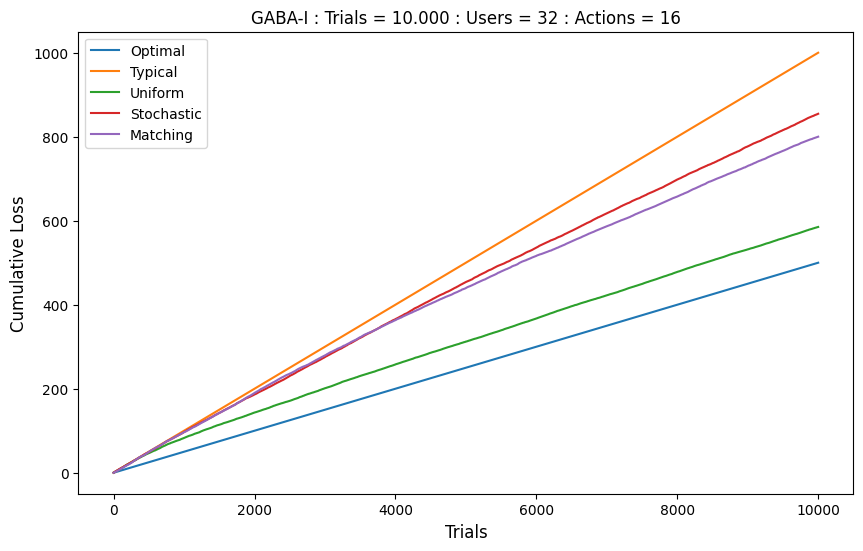

In [19]:
# GABA-I #

actions = 16
trials = 10000

start = time.time()
GABA_U = GABA_I(init_uniform)
GABA_S = GABA_I(init_stochastic)
GABA_M = GABA_I(init_matching)
end = time.time()

print(f'Time: {end - start}')

title = 'GABA-I : Trials = 10.000 : Users = 32 : Actions = 16'
plot([GABA_U, GABA_S, GABA_M], ['Uniform', 'Stochastic', 'Matching'], title)